In [1]:
#No89(事前学習済み言語モデルからの転移学習)
import pandas as pd
import re
import numpy as np
import random
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
#BERTをimportする
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda
from torch import nn
from matplotlib import pyplot as plt

# 乱数のシードを設定
# parserなどで指定
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

# ファイル読み込み
file = '/content/drive/MyDrive/newsCorpora.csv'
data = pd.read_csv(file, encoding='utf-8', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
data = data.replace('"', "'")
# 特定のpublisherのみ抽出
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
data = data.loc[data['PUBLISHER'].isin(publishers), ['TITLE', 'CATEGORY']].reset_index(drop=True)

# 前処理
def preprocessing(text):
    text_clean = re.sub(r'[\"\'.,:;\(\)#\|\*\+\!\?#$%&/\]\[\{\}]', '', text)
    text_clean = re.sub('[0-9]+', '0', text_clean)
    text_clean = re.sub('\s-\s', ' ', text_clean)
    return text_clean

data['TITLE'] = data['TITLE'].apply(preprocessing)

# 学習用、検証用、評価用に分割する
from sklearn.model_selection import train_test_split

train, valid_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=64, stratify=data['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=64, stratify=valid_test['CATEGORY'])

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

# データ数の確認
print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

# ターゲットのテンソル化
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
Y_train = torch.from_numpy(train['CATEGORY'].map(category_dict).values)
Y_valid = torch.from_numpy(valid['CATEGORY'].map(category_dict).values)
Y_test = torch.from_numpy(test['CATEGORY'].map(category_dict).values)

学習データ
CATEGORY
e    1617
b    1442
t     399
m     251
Name: count, dtype: int64
検証データ
CATEGORY
e    202
b    180
t     50
m     32
Name: count, dtype: int64
評価データ
CATEGORY
e    203
b    180
t     50
m     31
Name: count, dtype: int64


In [2]:
#単語をトークン化する
class BERTDataSet(Dataset):

    def __init__(self, X, y, phase):
        self.X = X['TITLE']
        self.y = y
        #事前学習されたトークナイザー
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.phase = phase

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        sentence = self.X[idx]
        sentence = str(sentence)
        #sentenceをsplitしたものを結合する
        sentence = " ".join(sentence.split())

        bert_sens = self.tokenizer.encode_plus(
                                sentence,
                                #文の先頭にCLS、文の区切りにSEPを挿入する
                                add_special_tokens = True, # [CLS],[SEP]
                                max_length = 20,
                                #長さを揃える
                                pad_to_max_length = True, # add padding to blank
                                truncation=True)
        #tensor化する
        ids = torch.tensor(bert_sens['input_ids'], dtype=torch.long)
        mask = torch.tensor(bert_sens['attention_mask'], dtype=torch.long)
        labels = self.y[idx]

        return {
                'ids': ids,
                'mask': mask,
                'labels': labels,
                }

train_dataset = BERTDataSet(train, Y_train, phase='train')
valid_dataset = BERTDataSet(valid, Y_valid, phase='val')
test_dataset = BERTDataSet(test, Y_test, phase='val')

# 動作確認
train_dataset[0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'ids': tensor([  101,  2691, 21183, 24226, 10882, 12618,  3593,  5970,  2064,  3659,
          6151, 12870, 10985,  4456, 17473, 19428,   102,     0,     0,     0]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]),
 'labels': tensor(3)}

In [3]:
# DataLoaderを作成
batch_size = 64

train_dataloader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
valid_dataloader = DataLoader(
            valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_dataloader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker, generator=g)

dataloaders_dict = {'train': train_dataloader,
                    'val': valid_dataloader,
                    'test': test_dataloader,
                   }

# 動作確認
batch_iter = iter(dataloaders_dict['train'])
inputs = next(batch_iter)
print(inputs['ids'].size())
print(inputs['mask'].size())
print(inputs['labels'].size())

torch.Size([64, 20])
torch.Size([64, 20])
torch.Size([64])


In [4]:
# BERT分類モデルの定義
class BERTClass(torch.nn.Module):
    def __init__(self, drop_rate, hidden_size, output_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        #過学習の防止
        self.drop = nn.Dropout(drop_rate)
        #768次元の単語ベクトル
        self.fc = nn.Sequential(
                                nn.Linear(768, hidden_size),
                                nn.ReLU(),
                                #Batch正規化
                                nn.BatchNorm1d(hidden_size),
                                nn.Linear(hidden_size, output_size)
                                )
        # self.fc = nn.Linear(768, output_size)  # BERTの出力に合わせて768次元を指定

    def forward(self, ids, mask):
        out = self.bert(ids, attention_mask=mask)[-1]
        out = self.fc(self.drop(out))
        return out

Tesla T4
使用デバイス: cuda:0
Epoch 1 / 8 (train) Loss: 1.0142, Acc: 0.5864, (val) Loss: 0.5440, Acc: 0.8147
Epoch 2 / 8 (train) Loss: 0.4943, Acc: 0.8504, (val) Loss: 0.3083, Acc: 0.8987
Epoch 3 / 8 (train) Loss: 0.3176, Acc: 0.9078, (val) Loss: 0.2295, Acc: 0.9267
Epoch 4 / 8 (train) Loss: 0.2187, Acc: 0.9399, (val) Loss: 0.2050, Acc: 0.9461
Epoch 5 / 8 (train) Loss: 0.1625, Acc: 0.9574, (val) Loss: 0.2016, Acc: 0.9418
Epoch 6 / 8 (train) Loss: 0.1177, Acc: 0.9714, (val) Loss: 0.2143, Acc: 0.9440
Epoch 7 / 8 (train) Loss: 0.0950, Acc: 0.9806, (val) Loss: 0.2028, Acc: 0.9440
Epoch 8 / 8 (train) Loss: 0.0745, Acc: 0.9822, (val) Loss: 0.2138, Acc: 0.9483


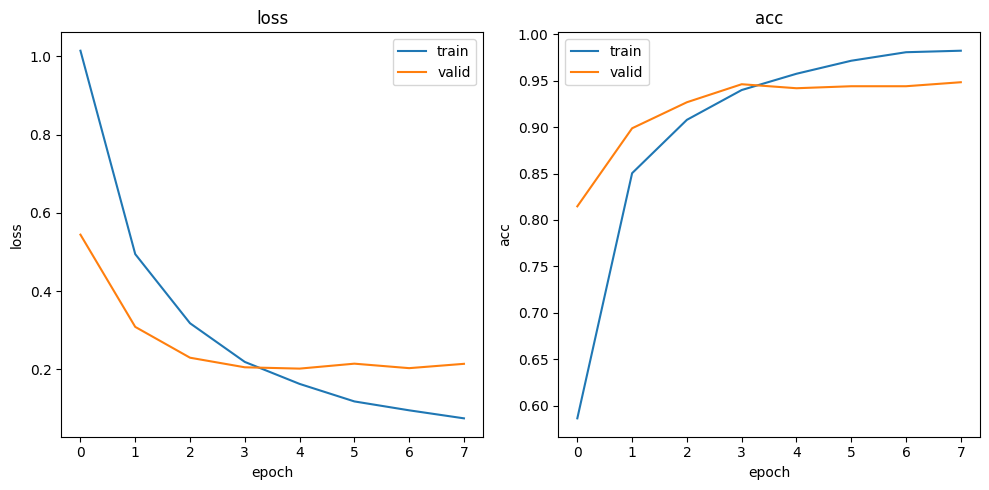

In [9]:
# 学習用の関数を定義
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    # 初期設定
    # GPUが使えるか確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(torch.cuda.get_device_name())
    print("使用デバイス:", device)

    # ネットワークをgpuへ
    net.to(device)

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() # 訓練モード
            else:
                net.eval() # 検証モード

            epoch_loss = 0.0 # epochの損失和
            epoch_corrects = 0 # epochの正解数

            # データローダーからミニバッチを取り出すループ
            for data in dataloaders_dict[phase]:
                # GPUが使えるならGPUにおくる
                ids = data['ids'].to(device)
                mask = data['mask'].to(device)
                labels = data['labels'].to(device)
                optimizer.zero_grad() # optimizerを初期化

                # 順伝播計算(forward)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(ids, mask)
                    loss = criterion(outputs, labels) # 損失を計算
                    _, preds = torch.max(outputs, 1) # ラベルを予想

                    # 訓練時は逆伝播
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イテレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * ids.size(0)
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率の表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.cpu())
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc.cpu())

        print('Epoch {} / {} (train) Loss: {:.4f}, Acc: {:.4f}, (val) Loss: {:.4f}, Acc: {:.4f}'.format(epoch + 1, num_epochs, train_loss[-1], train_acc[-1], valid_loss[-1], valid_acc[-1]))
    return train_loss, train_acc, valid_loss, valid_acc


# パラメータの設定
DROP_RATE = 0.2
HIDDEN_SIZE = 256
OUTPUT_SIZE = 4
BATCH_SIZE = 64
NUM_EPOCHS = 8
LEARNING_RATE = 1e-5

# モデルの定義
net = BERTClass(DROP_RATE, HIDDEN_SIZE, OUTPUT_SIZE)
net.train()

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.AdamW(params=net.parameters(), lr=LEARNING_RATE)

train_loss, train_acc, valid_loss, valid_acc = train_model(net,
            dataloaders_dict, criterion, optimizer, num_epochs=NUM_EPOCHS)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
epochs = np.arange(NUM_EPOCHS)
ax[0].plot(epochs, train_loss, label='train')
ax[0].plot(epochs, valid_loss, label='valid')
ax[0].set_title('loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[1].plot(epochs, train_acc, label='train')
ax[1].plot(epochs, valid_acc, label='valid')
ax[1].set_title('acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[0].legend(loc='best')
ax[1].legend(loc='best')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/fig89.png')
plt.show()
